### Fine-tuning SpeechT5

Now that you are familiar with the text-to-speech task and internal workings of the SpeechT5 model that was pre-trained on English language data, let’s see how we can fine-tune it to another language.

You’ll also need some additional dependencies:

In [1]:
!pip install transformers datasets soundfile speechbrain accelerate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 864.1/864.1 kB 40.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 64.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 35.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Finally, don’t forget to log in to your Hugging Face account so that you could upload and share your model with the community:

In [2]:
from huggingface_hub import notebook_login
notebook_login()

**The dataset**

For this example we’ll take the Dutch (nl) language subset of the VoxPopuli dataset. VoxPopuli is a large-scale multilingual speech corpus consisting of data sourced from 2009-2020 European Parliament event recordings. It contains labelled audio-transcription data for 15 European languages. While we will be using the Dutch language subset, feel free to pick another subset.

This is an automated speech recognition (ASR) dataset, so, as mentioned before, it is not the most suitable option for training TTS models. However, it will be good enough for this exercise.

Let’s load the data:

In [3]:
from datasets import load_dataset, Audio

dataset = load_dataset("facebook/multilingual_librispeech", "portuguese", split="train")
len(dataset)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/18.1k [00:00<?, ?B/s]

Resolving data files:   0%|          | 0/48 [00:00<?, ?it/s]

dev-00000-of-00001.parquet:   0%|          | 0.00/57.3M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/58.9M [00:00<?, ?B/s]

train-00000-of-00006.parquet:   0%|          | 0.00/429M [00:00<?, ?B/s]

train-00001-of-00006.parquet:   0%|          | 0.00/419M [00:00<?, ?B/s]

train-00002-of-00006.parquet:   0%|          | 0.00/406M [00:00<?, ?B/s]

train-00003-of-00006.parquet:   0%|          | 0.00/408M [00:00<?, ?B/s]

train-00004-of-00006.parquet:   0%|          | 0.00/426M [00:00<?, ?B/s]

train-00005-of-00006.parquet:   0%|          | 0.00/421M [00:00<?, ?B/s]

9_hours-00000-of-00001.parquet:   0%|          | 0.00/141M [00:00<?, ?B/s]

1_hours-00000-of-00001.parquet:   0%|          | 0.00/15.6M [00:00<?, ?B/s]

Generating dev split:   0%|          | 0/826 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/871 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/37533 [00:00<?, ? examples/s]

Generating 9_hours split:   0%|          | 0/2116 [00:00<?, ? examples/s]

Generating 1_hours split:   0%|          | 0/236 [00:00<?, ? examples/s]

37533

In [4]:
dataset = dataset.cast_column("audio", Audio(sampling_rate=16000))

**Preprocessing the data**

Let’s begin by defining the model checkpoint to use and loading the appropriate processor that contains both tokenizer, and feature extractor that we will need to prepare the data for training:

In [5]:
from transformers import SpeechT5Processor

checkpoint = "microsoft/speecht5_tts"
processor = SpeechT5Processor.from_pretrained(checkpoint)

preprocessor_config.json:   0%|          | 0.00/433 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/232 [00:00<?, ?B/s]

spm_char.model:   0%|          | 0.00/238k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/40.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/234 [00:00<?, ?B/s]

**Text cleanup for SpeechT5 tokenization**

First, for preparing the text, we’ll need the tokenizer part of the processor, so let’s get it:

In [6]:
tokenizer = processor.tokenizer

In [7]:
#Let’s take a look at an example:
dataset[0]

{'audio': {'path': '12249_10229_000000.opus',
  'array': array([-0.00026572, -0.0002681 , -0.0002242 , ...,  0.00018133,
          0.00024239,  0.00040742]),
  'sampling_rate': 16000},
 'original_path': 'http://www.archive.org/download/canaa_1901_librivox/canaa_12_aranha_64kb.mp3',
 'begin_time': 617.09,
 'end_time': 635.04,
 'transcript': 'e quando ia sendo arrebatado pela expansão dos seus mais íntimos anceios maciel conteve-se com esforço ficou repentinamente mudo fitando com os olhos vermelhos e húmidos o extrangeiro',
 'audio_duration': 17.949999999999932,
 'speaker_id': '12249',
 'chapter_id': '10229',
 'file': '12249_10229_000000.opus',
 'id': '12249_10229_000000'}

What you may notice is that the dataset examples contain *transcript* feature. When deciding which feature to use as the text input, it will be important to know that the SpeechT5 tokenizer doesn’t have any tokens for numbers. In normalized_text the numbers are written out as text. Thus, it is a better fit, and we should use normalized_text as input text.

Because SpeechT5 was trained on the English language, it may not recognize certain characters in the Dutch dataset. If left as is, these characters will be converted to <unk> tokens. However, in Dutch, certain characters like à are used to stress syllables. In order to preserve the meaning of the text, we can replace this character with a regular a.

To identify unsupported tokens, extract all unique characters in the dataset using the SpeechT5Tokenizer which works with characters as tokens. To do this, we’ll write the extract_all_chars mapping function that concatenates the transcriptions from all examples into one string and converts it to a set of characters. Make sure to set batched=True and batch_size=-1 in dataset.map() so that all transcriptions are available at once for the mapping function.

In [8]:
def extract_all_chars(batch):
    all_text = " ".join(batch["transcript"])
    vocab = list(set(all_text))
    return {"vocab": [vocab], "all_text": [all_text]}


vocabs = dataset.map(
    extract_all_chars,
    batched=True,
    batch_size=-1,
    keep_in_memory=True,
    remove_columns=dataset.column_names,
)

dataset_vocab = set(vocabs["vocab"][0])
tokenizer_vocab = {k for k, _ in tokenizer.get_vocab().items()}

Map:   0%|          | 0/37533 [00:00<?, ? examples/s]

Now you have two sets of characters: one with the vocabulary from the dataset and one with the vocabulary from the tokenizer. To identify any unsupported characters in the dataset, you can take the difference between these two sets. The resulting set will contain the characters that are in the dataset but not in the tokenizer.

In [9]:
dataset_vocab - tokenizer_vocab

{' ', 'à', 'á', 'â', 'ã', 'ç', 'í', 'ò', 'ó', 'ô', 'õ', 'ú', 'ü'}

To handle the unsupported characters identified in the previous step, we can define a function that maps these characters to valid tokens. Note that spaces are already replaced by ▁ in the tokenizer and don’t need to be handled separately.

In [13]:
replacements = [
    ("à", "a"),
    ("á", "a"),
    ("ã", "a"),
    ("ã", "a"),
    ("ç", "c"),
    ("í", "i"),
    ("ò", "o"),
    ("ó", "o"),
    ("ô", "o"),
    ("õ", "o"),
    ("ú", "u"),
    ("ü", "u")
]


def cleanup_text(inputs):
    for src, dst in replacements:
        inputs["transcript"] = inputs["transcript"].replace(src, dst)
    return inputs


dataset = dataset.map(cleanup_text)

Map:   0%|          | 0/37533 [00:00<?, ? examples/s]

Now that we have dealt with special characters in the text, it’s time to shift the focus to the audio data.

**Speakers**

The VoxPopuli dataset includes speech from multiple speakers, but how many speakers are represented in the dataset? To determine this, we can count the number of unique speakers and the number of examples each speaker contributes to the dataset. With a total of 20,968 examples in the dataset, this information will give us a better understanding of the distribution of speakers and examples in the data.

In [14]:
from collections import defaultdict

speaker_counts = defaultdict(int)

for speaker_id in dataset["speaker_id"]:
    speaker_counts[speaker_id] += 1

By plotting a histogram you can get a sense of how much data there is for each speaker.

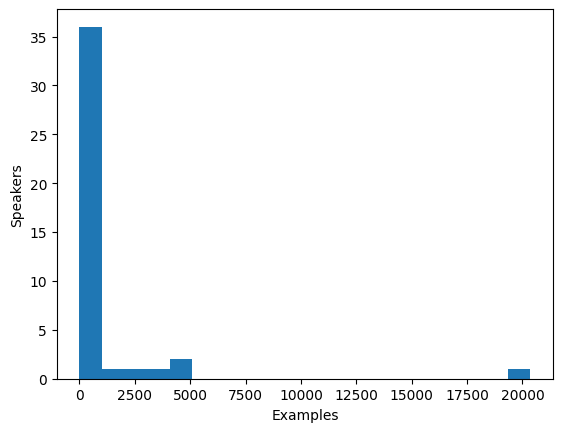

In [15]:
import matplotlib.pyplot as plt

plt.figure()
plt.hist(speaker_counts.values(), bins=20)
plt.ylabel("Speakers")
plt.xlabel("Examples")
plt.show()

The histogram reveals that approximately one-third of the speakers in the dataset have fewer than 100 examples, while around ten speakers have more than 500 examples. To improve training efficiency and balance the dataset, we can limit the data to speakers with between 100 and 400 examples.

In [19]:
def select_speaker(speaker_id):
    return 100 <= speaker_counts[speaker_id] <= 400

dataset = dataset.filter(select_speaker, input_columns=["speaker_id"])

Let’s check how many speakers remain:

In [20]:
len(set(dataset["speaker_id"]))

0

Let’s see how many examples are left:

In [21]:
len(dataset)

0

You are left with just under 10,000 examples from approximately 40 unique speakers, which should be sufficient.

Note that some speakers with few examples may actually have more audio available if the examples are long. However, determining the total amount of audio for each speaker requires scanning through the entire dataset, which is a time-consuming process that involves loading and decoding each audio file. As such, we have chosen to skip this step here.

**Speaker embeddings**

To enable the TTS model to differentiate between multiple speakers, you’ll need to create a speaker embedding for each example. The speaker embedding is an additional input into the model that captures a particular speaker’s voice characteristics. To generate these speaker embeddings, use the pre-trained spkrec-xvect-voxceleb model from SpeechBrain.

Create a function create_speaker_embedding() that takes an input audio waveform and outputs a 512-element vector containing the corresponding speaker embedding.

In [24]:
#!pip install speechbrain

In [25]:
import os
import torch
from speechbrain.pretrained import EncoderClassifier

spk_model_name = "speechbrain/spkrec-xvect-voxceleb"

device = "cuda" if torch.cuda.is_available() else "cpu"

speaker_model = EncoderClassifier.from_hparams(
    source=spk_model_name,
    run_opts={"device": device},
    savedir=os.path.join("/tmp", spk_model_name),
)

def create_speaker_embedding(waveform):
    with torch.no_grad():
        speaker_embeddings = speaker_model.encode_batch(torch.tensor(waveform))
        speaker_embeddings = torch.nn.functional.normalize(speaker_embeddings, dim=2)
        speaker_embeddings = speaker_embeddings.squeeze().cpu().numpy()
    return speaker_embeddings

DEBUG:speechbrain.utils.checkpoints:Registered checkpoint save hook for _speechbrain_save
DEBUG:speechbrain.utils.checkpoints:Registered checkpoint load hook for _speechbrain_load
DEBUG:speechbrain.utils.checkpoints:Registered checkpoint save hook for save
DEBUG:speechbrain.utils.checkpoints:Registered checkpoint load hook for load
DEBUG:speechbrain.utils.checkpoints:Registered checkpoint save hook for _save
DEBUG:speechbrain.utils.checkpoints:Registered checkpoint load hook for _recover
<ipython-input-25-9cb8ea371e3b>:3: UserWarning: Module 'speechbrain.pretrained' was deprecated, redirecting to 'speechbrain.inference'. Please update your script. This is a change from SpeechBrain 1.0. See: https://github.com/speechbrain/speechbrain/releases/tag/v1.0.0
  from speechbrain.pretrained import EncoderClassifier
INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Fetching from HuggingFace Hub 'speechbrain/spkrec-xvect-voxceleb' if not cached


hyperparams.yaml:   0%|          | 0.00/2.04k [00:00<?, ?B/s]

DEBUG:speechbrain.utils.fetching:Fetch: Local file found, creating symlink '/root/.cache/huggingface/hub/models--speechbrain--spkrec-xvect-voxceleb/snapshots/56895a2df401be4150a159f3a1c653f00051d477/hyperparams.yaml' -> '/tmp/speechbrain/spkrec-xvect-voxceleb/hyperparams.yaml'
INFO:speechbrain.utils.fetching:Fetch custom.py: Fetching from HuggingFace Hub 'speechbrain/spkrec-xvect-voxceleb' if not cached
DEBUG:speechbrain.utils.checkpoints:Registered checkpoint save hook for _save
DEBUG:speechbrain.utils.checkpoints:Registered checkpoint load hook for _load
DEBUG:speechbrain.utils.checkpoints:Registered parameter transfer hook for _load
/usr/local/lib/python3.11/dist-packages/speechbrain/utils/autocast.py:188: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  wrapped_fwd = torch.cuda.amp.custom_fwd(fwd, cast_inputs=cast_inputs)
DEBUG:speechbrain.utils.checkpoints:Registered checkpoint save hook fo

embedding_model.ckpt:   0%|          | 0.00/16.9M [00:00<?, ?B/s]

DEBUG:speechbrain.utils.fetching:Fetch: Local file found, creating symlink '/root/.cache/huggingface/hub/models--speechbrain--spkrec-xvect-voxceleb/snapshots/56895a2df401be4150a159f3a1c653f00051d477/embedding_model.ckpt' -> '/tmp/speechbrain/spkrec-xvect-voxceleb/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /tmp/speechbrain/spkrec-xvect-voxceleb/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch mean_var_norm_emb.ckpt: Fetching from HuggingFace Hub 'speechbrain/spkrec-xvect-voxceleb' if not cached


mean_var_norm_emb.ckpt:   0%|          | 0.00/3.20k [00:00<?, ?B/s]

DEBUG:speechbrain.utils.fetching:Fetch: Local file found, creating symlink '/root/.cache/huggingface/hub/models--speechbrain--spkrec-xvect-voxceleb/snapshots/56895a2df401be4150a159f3a1c653f00051d477/mean_var_norm_emb.ckpt' -> '/tmp/speechbrain/spkrec-xvect-voxceleb/mean_var_norm_emb.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["mean_var_norm_emb"] = /tmp/speechbrain/spkrec-xvect-voxceleb/mean_var_norm_emb.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Fetching from HuggingFace Hub 'speechbrain/spkrec-xvect-voxceleb' if not cached


classifier.ckpt:   0%|          | 0.00/15.9M [00:00<?, ?B/s]

DEBUG:speechbrain.utils.fetching:Fetch: Local file found, creating symlink '/root/.cache/huggingface/hub/models--speechbrain--spkrec-xvect-voxceleb/snapshots/56895a2df401be4150a159f3a1c653f00051d477/classifier.ckpt' -> '/tmp/speechbrain/spkrec-xvect-voxceleb/classifier.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["classifier"] = /tmp/speechbrain/spkrec-xvect-voxceleb/classifier.ckpt
INFO:speechbrain.utils.fetching:Fetch label_encoder.txt: Fetching from HuggingFace Hub 'speechbrain/spkrec-xvect-voxceleb' if not cached


label_encoder.txt:   0%|          | 0.00/129k [00:00<?, ?B/s]

DEBUG:speechbrain.utils.fetching:Fetch: Local file found, creating symlink '/root/.cache/huggingface/hub/models--speechbrain--spkrec-xvect-voxceleb/snapshots/56895a2df401be4150a159f3a1c653f00051d477/label_encoder.txt' -> '/tmp/speechbrain/spkrec-xvect-voxceleb/label_encoder.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["label_encoder"] = /tmp/speechbrain/spkrec-xvect-voxceleb/label_encoder.ckpt
INFO:speechbrain.utils.parameter_transfer:Loading pretrained files for: embedding_model, mean_var_norm_emb, classifier, label_encoder
DEBUG:speechbrain.utils.parameter_transfer:Redirecting (loading from local path): embedding_model -> /tmp/speechbrain/spkrec-xvect-voxceleb/embedding_model.ckpt
DEBUG:speechbrain.utils.parameter_transfer:Redirecting (loading from local path): mean_var_norm_emb -> /tmp/speechbrain/spkrec-xvect-voxceleb/mean_var_norm_emb.ckpt
DEBUG:speechbrain.utils.parameter_transfer:Redirecting (loading from local path): classifier -> /tmp/speechbra

It’s important to note that the speechbrain/spkrec-xvect-voxceleb model was trained on English speech from the VoxCeleb dataset, whereas the training examples in this guide are in Dutch. While we believe that this model will still generate reasonable speaker embeddings for our Dutch dataset, this assumption may not hold true in all cases.

For optimal results, we would need to train an X-vector model on the target speech first. This will ensure that the model is better able to capture the unique voice characteristics present in the Dutch language. If you’d like to train your own X-vector model, you can use this script as an example.

**Processing the dataset**

Finally, let’s process the data into the format the model expects. Create a prepare_dataset function that takes in a single example and uses the SpeechT5Processor object to tokenize the input text and load the target audio into a log-mel spectrogram. It should also add the speaker embeddings as an additional input.

In [26]:
def prepare_dataset(example):
    audio = example["audio"]

    example = processor(
        text=example["transcript"],
        audio_target=audio["array"],
        sampling_rate=audio["sampling_rate"],
        return_attention_mask=False,
    )

    # strip off the batch dimension
    example["labels"] = example["labels"][0]

    # use SpeechBrain to obtain x-vector
    example["speaker_embeddings"] = create_speaker_embedding(audio["array"])

    return example

Verify the processing is correct by looking at a single example:

In [27]:
processed_example = prepare_dataset(dataset[0])
list(processed_example.keys())

IndexError: Invalid key: 0 is out of bounds for size 0